The objective in this project is to answer a couple of different questions using Pyspark for it
Given the size of the Dataset and the questions it could be easily done using python's pandas library alone, however as our objective here is to also develop a solution that could be used with a huge Dataset the use of Bigdata Frameworks such as Spark, DASK and others appears as an obvious solution

1. Number of deaths per year
2. Number of deaths grouped by sex
3. Number of deaths grouped by cause of death
4. Number of deaths grouped by cause of deaths and sex
5. Main cause of deaths for each one of the ethnic group in the Dataset
6. Sex distribution of the Dataset

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql.functions import udf
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import  translate
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col
from pyspark.sql.functions import row_number

import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sc = SparkContext(appName='Nyc Death Causes')

22/08/22 23:12:22 WARN Utils: Your hostname, rodrigo-Dell-G15-5511 resolves to a loopback address: 127.0.1.1; using 192.168.15.132 instead (on interface wlp0s20f3)
22/08/22 23:12:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 23:12:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sc

<SparkContext master=local[*] appName=Nyc Death Causes>

In [5]:
spark = SparkSession.builder.getOrCreate()

In [6]:
file = '../data/New_York_City_Leading_Causes_of_Death.csv'
nycDF = spark.read.csv(file,inferSchema=True, header=True)

In [7]:
nycDF.show(5)

+----+--------------------+---+--------------------+------+----------+-----------------------+
|Year|       Leading Cause|Sex|      Race Ethnicity|Deaths|Death Rate|Age Adjusted Death Rate|
+----+--------------------+---+--------------------+------+----------+-----------------------+
|2009|Nephritis, Nephro...|  F|Other Race/ Ethni...|     .|         .|                      .|
|2013|Influenza (Flu) a...|  F|            Hispanic|   204|      16.3|                   18.5|
|2012|Assault (Homicide...|  M|Other Race/ Ethni...|     .|         .|                      .|
|2007|Essential Hyperte...|  F|  Not Stated/Unknown|     5|         .|                      .|
|2014|Cerebrovascular D...|  F|  White Non-Hispanic|   418|      29.5|                   15.6|
+----+--------------------+---+--------------------+------+----------+-----------------------+
only showing top 5 rows



In [8]:
nycDF.dtypes

[('Year', 'int'),
 ('Leading Cause', 'string'),
 ('Sex', 'string'),
 ('Race Ethnicity', 'string'),
 ('Deaths', 'string'),
 ('Death Rate', 'string'),
 ('Age Adjusted Death Rate', 'string')]

On the next cell i'm gonna try to use an inputation technique that i think is gonna work for this data.
On the data dictionary it's said that every register with under 5 deaths is supressed on the Dataset
So i'm gonna try to input it with 2 given that it's almost in the middle

In [9]:
nycDF = nycDF.withColumn('Deaths', translate('Deaths', ". ", "2"))
nycDF = nycDF.withColumn('Deaths', nycDF.Deaths.cast(IntegerType()))
nycDF.show(5)

+----+--------------------+---+--------------------+------+----------+-----------------------+
|Year|       Leading Cause|Sex|      Race Ethnicity|Deaths|Death Rate|Age Adjusted Death Rate|
+----+--------------------+---+--------------------+------+----------+-----------------------+
|2009|Nephritis, Nephro...|  F|Other Race/ Ethni...|     2|         .|                      .|
|2013|Influenza (Flu) a...|  F|            Hispanic|   204|      16.3|                   18.5|
|2012|Assault (Homicide...|  M|Other Race/ Ethni...|     2|         .|                      .|
|2007|Essential Hyperte...|  F|  Not Stated/Unknown|     5|         .|                      .|
|2014|Cerebrovascular D...|  F|  White Non-Hispanic|   418|      29.5|                   15.6|
+----+--------------------+---+--------------------+------+----------+-----------------------+
only showing top 5 rows



In [10]:
nycDF = nycDF.replace(['Female','Male'],['F','M'])
nycDF = nycDF.replace(['Non-Hispanic White','Non-Hispanic Black'],['White Non-Hispanic','Black Non-Hispanic'])

The number of samples in the dataset per sex

In [11]:
nycDF.groupBy("Sex").count().show()

+---+-----+
|Sex|count|
+---+-----+
|  F|  644|
|  M|  628|
+---+-----+



Number of deaths per sex

In [12]:
nycDF.groupBy('Sex').sum('Deaths').show()

+---+-----------+
|Sex|sum(Deaths)|
+---+-----------+
|  F|     244139|
|  M|     235694|
+---+-----------+



In [13]:
def configure_plotly_browser_state():
  
  import IPython
  
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.43.1.min.js?noext',
            },
          });
        </script>
        '''))

In [14]:
dfNumDeaths = nycDF.groupBy('Sex').sum('Deaths').toPandas()
configure_plotly_browser_state()
px.bar(data_frame=dfNumDeaths, x = 'Sex', y = 'sum(Deaths)', title = "Number of deaths per sex",labels = {"sum(Deaths)":"Num of Deaths"}, width=600, height = 400)

The number of deaths per year

In [15]:
nycDF.groupBy('Year').agg({'Deaths':'sum'}).sort("Year").show()

+----+-----------+
|Year|sum(Deaths)|
+----+-----------+
|2007|      54048|
|2008|      54176|
|2009|      52864|
|2010|      52549|
|2011|      52774|
|2012|      52444|
|2013|      53399|
|2014|      53020|
|2019|      54559|
+----+-----------+



In [16]:
dfDeathsPerYear = nycDF.groupBy('Year').agg({'Deaths':'sum'}).sort("Year").toPandas()
configure_plotly_browser_state()
px.bar(data_frame=dfDeathsPerYear, x = 'Year', y = 'sum(Deaths)', title = "Number of deaths per sex",labels = {"sum(Deaths)":"Num of Deaths"}, width = 800)
#The data for 2015, 2016, 2017 is not in the Dataset

Number of Deaths per Year/Sex

In [17]:
nycDF.groupBy(["Year","Sex"]).agg({'Deaths':'Sum'}).sort("Year").show()

+----+---+-----------+
|Year|Sex|sum(Deaths)|
+----+---+-----------+
|2007|  F|      27787|
|2007|  M|      26261|
|2008|  F|      27840|
|2008|  M|      26336|
|2009|  F|      26969|
|2009|  M|      25895|
|2010|  M|      25848|
|2010|  F|      26701|
|2011|  M|      25669|
|2011|  F|      27105|
|2012|  M|      25662|
|2012|  F|      26782|
|2013|  F|      27139|
|2013|  M|      26260|
|2014|  M|      26090|
|2014|  F|      26930|
|2019|  M|      27673|
|2019|  F|      26886|
+----+---+-----------+



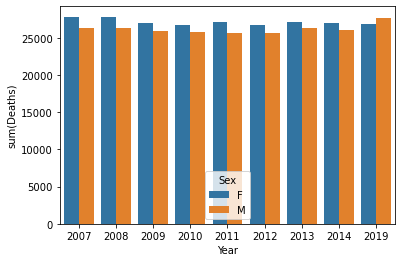

In [18]:
dfYearSexDeaths = nycDF.groupBy(["Year","Sex"]).agg({'Deaths':'Sum'}).sort("Year").toPandas()
#px.bar(data_frame=dfDeathsPerYear, x = 'Year', y = 'sum(Deaths)', title = "Number of deaths per sex",labels = {"sum(Deaths)":"Num of Deaths"},barmode='group', color = "Sex")
sns.barplot(data = dfYearSexDeaths, x = "Year", y ='sum(Deaths)', hue = "Sex");

In [19]:
nycDF.groupBy("Deaths").count().sort('count').show()

+------+-----+
|Deaths|count|
+------+-----+
|  1199|    1|
|   501|    1|
|   472|    1|
|   633|    1|
|  2366|    1|
|   496|    1|
|   540|    1|
|   530|    1|
|  1025|    1|
|   101|    1|
|  1507|    1|
|  1201|    1|
|   451|    1|
|   300|    1|
|   458|    1|
|  1163|    1|
|   255|    1|
|   988|    1|
|   243|    1|
|  1307|    1|
+------+-----+
only showing top 20 rows



Number of Deaths per Race Ethnicity

In [20]:
nycDF.groupBy('Race Ethnicity').agg({"Deaths":'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate = False)

+--------------------------+-----------+
|Race Ethnicity            |sum(Deaths)|
+--------------------------+-----------+
|White Non-Hispanic        |229122     |
|Black Non-Hispanic        |125829     |
|Hispanic                  |86062      |
|Asian and Pacific Islander|30953      |
|Not Stated/Unknown        |5061       |
|Other Race/ Ethnicity     |2806       |
+--------------------------+-----------+



In [21]:
nycDF.where(nycDF['Race Ethnicity'] == 'Black Non-Hispanic').groupBy('Leading Cause').agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate = 80)

+--------------------------------------------------------------------------------+-----------+
|                                                                   Leading Cause|sum(Deaths)|
+--------------------------------------------------------------------------------+-----------+
|                                  Diseases of Heart (I00-I09, I11, I13, I20-I51)|      40020|
|                                           Malignant Neoplasms (Cancer: C00-C97)|      30060|
|                                                                All Other Causes|      24491|
|                                                     Diabetes Mellitus (E10-E14)|       6201|
|                                         Influenza (Flu) and Pneumonia (J09-J18)|       4586|
|                                       Cerebrovascular Disease (Stroke: I60-I69)|       4193|
|                             Human Immunodeficiency Virus Disease (HIV: B20-B24)|       3583|
|                                    Chronic Lower

Main cause of death for Sex == Masculine

In [22]:
nycDF.where(nycDF.Sex == 'M').groupBy("Leading Cause").sum('Deaths').sort("sum(Deaths)", ascending = False).show(truncate = 80)

+--------------------------------------------------------------------------------+-----------+
|                                                                   Leading Cause|sum(Deaths)|
+--------------------------------------------------------------------------------+-----------+
|                                  Diseases of Heart (I00-I09, I11, I13, I20-I51)|      77760|
|                                           Malignant Neoplasms (Cancer: C00-C97)|      58653|
|                                                                All Other Causes|      45035|
|                                         Influenza (Flu) and Pneumonia (J09-J18)|       9755|
|                                                     Diabetes Mellitus (E10-E14)|       7565|
|                                    Chronic Lower Respiratory Diseases (J40-J47)|       6864|
|                                       Cerebrovascular Disease (Stroke: I60-I69)|       6156|
|                Accidents Except Drug Posioning (

Main causes of death for Sex == Feminine

In [23]:
nycDF.where(nycDF.Sex == 'F').groupBy("Leading Cause").sum('Deaths').sort("sum(Deaths)", ascending = False).show(truncate = 80)

+--------------------------------------------------------------------------------+-----------+
|                                                                   Leading Cause|sum(Deaths)|
+--------------------------------------------------------------------------------+-----------+
|                                  Diseases of Heart (I00-I09, I11, I13, I20-I51)|      87612|
|                                           Malignant Neoplasms (Cancer: C00-C97)|      60162|
|                                                                All Other Causes|      44574|
|                                         Influenza (Flu) and Pneumonia (J09-J18)|      10563|
|                                       Cerebrovascular Disease (Stroke: I60-I69)|       8682|
|                                    Chronic Lower Respiratory Diseases (J40-J47)|       8183|
|                                                     Diabetes Mellitus (E10-E14)|       8135|
|                            Essential Hypertensio

Main causes of death for White Non-Hispanic

In [24]:
nycDF.where(nycDF['Race Ethnicity'] == 'White Non-Hispanic').groupBy('Leading Cause').agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate = 80)

+--------------------------------------------------------------------------------+-----------+
|                                                                   Leading Cause|sum(Deaths)|
+--------------------------------------------------------------------------------+-----------+
|                                  Diseases of Heart (I00-I09, I11, I13, I20-I51)|      89595|
|                                           Malignant Neoplasms (Cancer: C00-C97)|      58116|
|                                                                All Other Causes|      38376|
|                                         Influenza (Flu) and Pneumonia (J09-J18)|      10257|
|                                    Chronic Lower Respiratory Diseases (J40-J47)|       7938|
|                                       Cerebrovascular Disease (Stroke: I60-I69)|       6022|
|                                                     Diabetes Mellitus (E10-E14)|       4457|
|                Accidents Except Drug Posioning (

Main causes of death for Black Non-Hispanic

In [25]:
nycDF.where(nycDF['Race Ethnicity'] == 'Black Non-Hispanic').groupBy('Leading Cause').agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate = 80)

+--------------------------------------------------------------------------------+-----------+
|                                                                   Leading Cause|sum(Deaths)|
+--------------------------------------------------------------------------------+-----------+
|                                  Diseases of Heart (I00-I09, I11, I13, I20-I51)|      40020|
|                                           Malignant Neoplasms (Cancer: C00-C97)|      30060|
|                                                                All Other Causes|      24491|
|                                                     Diabetes Mellitus (E10-E14)|       6201|
|                                         Influenza (Flu) and Pneumonia (J09-J18)|       4586|
|                                       Cerebrovascular Disease (Stroke: I60-I69)|       4193|
|                             Human Immunodeficiency Virus Disease (HIV: B20-B24)|       3583|
|                                    Chronic Lower

Main causes of Death for Hispanic

In [26]:
nycDF.where(nycDF['Race Ethnicity'] == 'Hispanic').groupBy('Leading Cause').agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate = 80)

+--------------------------------------------------------------------------------+-----------+
|                                                                   Leading Cause|sum(Deaths)|
+--------------------------------------------------------------------------------+-----------+
|                                  Diseases of Heart (I00-I09, I11, I13, I20-I51)|      24240|
|                                           Malignant Neoplasms (Cancer: C00-C97)|      19908|
|                                                                All Other Causes|      19597|
|                                         Influenza (Flu) and Pneumonia (J09-J18)|       3688|
|                                                     Diabetes Mellitus (E10-E14)|       3651|
|                                       Cerebrovascular Disease (Stroke: I60-I69)|       2991|
|                                    Chronic Lower Respiratory Diseases (J40-J47)|       2540|
|Mental and Behavioral Disorders due to Accidental

In [27]:
nycDF.where(nycDF['Race Ethnicity'] == 'Asian and Pacific Islander').groupBy('Leading Cause').agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate = 80)

+-------------------------------------------------------------------------------+-----------+
|                                                                  Leading Cause|sum(Deaths)|
+-------------------------------------------------------------------------------+-----------+
|                                          Malignant Neoplasms (Cancer: C00-C97)|       9180|
|                                 Diseases of Heart (I00-I09, I11, I13, I20-I51)|       8863|
|                                                               All Other Causes|       5547|
|                                        Influenza (Flu) and Pneumonia (J09-J18)|       1487|
|                                      Cerebrovascular Disease (Stroke: I60-I69)|       1448|
|                                                    Diabetes Mellitus (E10-E14)|       1073|
|                                   Chronic Lower Respiratory Diseases (J40-J47)|        865|
|               Accidents Except Drug Posioning (V01-X39, X4

Which Sex is more victim of homicide
The result is impressive, we can see the Black and Hispanic men are much more likely to die by Homicide than Women of all Ethnicity
By making a simple division we can conclude that men are around 250 times more prone to die from Homicide then Women

In [28]:
nycDF.where(nycDF['Leading Cause'].contains('Homicide')).groupBy(['Race Ethnicity','Sex']).agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate=80)

+---------------------+---+-----------+
|       Race Ethnicity|Sex|sum(Deaths)|
+---------------------+---+-----------+
|   Black Non-Hispanic|  M|       2124|
|             Hispanic|  M|        114|
|   Not Stated/Unknown|  M|         17|
|Other Race/ Ethnicity|  M|         15|
|Other Race/ Ethnicity|  F|          7|
|   Not Stated/Unknown|  F|          2|
+---------------------+---+-----------+



In [29]:
nycDF.where(nycDF['Leading Cause'].contains('Mental and Behavioral Disorders')).groupBy(['Race Ethnicity','Sex']).agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate=80)

+---------------------+---+-----------+
|       Race Ethnicity|Sex|sum(Deaths)|
+---------------------+---+-----------+
|   White Non-Hispanic|  M|       2464|
|             Hispanic|  M|       1758|
|   Black Non-Hispanic|  M|        592|
|   White Non-Hispanic|  F|        374|
|             Hispanic|  F|        280|
|   Black Non-Hispanic|  F|        207|
|   Not Stated/Unknown|  M|        102|
|Other Race/ Ethnicity|  M|         31|
|   Not Stated/Unknown|  F|         19|
|Other Race/ Ethnicity|  F|          9|
+---------------------+---+-----------+



The same can be said about HIV related deaths
Black and Hispanic people are much more likely to die from this cause

In [30]:
nycDF.where(nycDF['Leading Cause'].contains('HIV')).groupBy(['Race Ethnicity','Sex']).agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate=80)

+---------------------+---+-----------+
|       Race Ethnicity|Sex|sum(Deaths)|
+---------------------+---+-----------+
|   Black Non-Hispanic|  M|       2259|
|   Black Non-Hispanic|  F|       1324|
|             Hispanic|  M|       1304|
|             Hispanic|  F|        467|
|   Not Stated/Unknown|  M|         60|
|   Not Stated/Unknown|  F|         16|
|Other Race/ Ethnicity|  M|         15|
+---------------------+---+-----------+



In [31]:
#i've also decided to analyse this one because it's often associated with alcohol consumption
nycDF.where(nycDF['Leading Cause'].contains('Liver Disease')).groupBy(['Race Ethnicity','Sex']).agg({'Deaths':'Sum'}).sort("sum(Deaths)", ascending = False).show(truncate=80)

+--------------------------+---+-----------+
|            Race Ethnicity|Sex|sum(Deaths)|
+--------------------------+---+-----------+
|                  Hispanic|  M|       1319|
|                  Hispanic|  F|        183|
|Asian and Pacific Islander|  M|        133|
|        Not Stated/Unknown|  M|         40|
|     Other Race/ Ethnicity|  M|         25|
|        Not Stated/Unknown|  F|          8|
|     Other Race/ Ethnicity|  F|          2|
+--------------------------+---+-----------+

